# **One-step Methods For Solving Ordinary Differential Equation (ODE)**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Given an or a system of ODE(s) together with an initial condition, we can use **one-step methods** to solve Initial Value Problems (IVP). That means we iteratively approximate the value of a function based on the derivative (or the slope) of it at each step. The general (first order) ODE can be defined by
<br>
$y'(t) = f(y(t),t)$, $y(t_0) = y_0$, $t \in [t_0, t_{end}]$
<br>
with $f: \mathbb{R}^n \times [t_0, t_{\text{end}}] \to \mathbb{R}^n \quad \text{and} \quad y_0 \in \mathbb{R}^n$

### Explicit Euler method

This is a fixed-step method where the iteration is given by $y_{n+1} = y_n + h.f(t_n, y_n)$

In [3]:
def euler(f, t0, y0, t_end, h):
    # Initial condition as first elements of the lists
    t_values = [t0]
    y_values = [y0]

    # Euler iteration
    while t_values[-1] + h < t_end:
        t_n = t_values[-1]
        y_n = y_values[-1]

        # Update y and t lists
        y_values.append(y_n + h*f(t_n , y_n))
        t_values.append(t_n + h)

    return t_values, y_values

### Runge-Kutta 4th Order Method (RK4)

Another fixed step method with the convergence order of fourth defined by the Butcher Tableau

\begin{array}{c|cccc}
0 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
\hline
  & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}


In [11]:
def rk4(f, y0, t0, t_end, h):
    # Initial condition as first elements of the lists
    t_values = [t0]
    y_values = [y0]

    # Runge-Kutta 4 iteration
    while t_values[-1] + h < t_end:
        t_n = t_values[-1] 
        y_n = y_values[-1]

        # Compute k values
        k1 = f(t_n , y_n)
        k2 = f(t_n + h/2 , y_n + h/2*k1)
        k3 = f(t_n + h/2 , y_n + h/2*k2)
        k4 = f(t_n + h , y_n + h*k3)

        # Update y and t lists
        y_values.append(y_n + h * (1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4))
        t_values.append(t_n + h)

    return t_values, y_values

### Adaptive Runge-Kutta-2(3) Method

The last one is a method which can adjust its own step size after every iteration, defined by the Butcher Tableau
\begin{array}{c|ccc}
0   & 0   & 0   & 0   \\
1 & 1 & 0   & 0   \\
\frac{1}{2} & \frac{1}{4}   & \frac{1}{4} & 0   \\
\hline
     & \frac{1}{6} & \frac{1}{6} & \frac{4}{6} \\
     & \frac{1}{2} & \frac{1}{2} & 0
\end{array}
with an embedded second-order method. To increase the efficiency of a method $x_{n+1}$, it is useful to adjust the time step according to an error tolerance. For this purpose, a second method $\hat x_{n+1}$ of higher order is used, allowing the local error of the next step to be estimated 
<br>
$\epsilon := \| x_{n+1} - \hat{x}_{n+1} \|_{\infty} < \epsilon_{\text{tol}}$
<br>
with the maximum norm $\|v\|_{\infty} = \max \{ |v_i|, \, i = 1, \ldots, d \} \quad \text{for} \, v \in \mathbb{R}^d$. If the local error $\epsilon$ smaller than the given error tolerance $\epsilon_{tol}$, the step of the more accurate method is performed, and the step size is updated as follows:
<br>
$h_{n+1} = h \cdot \sqrt[3]{\lambda \cdot \frac{\epsilon_{\text{tol}}}{\epsilon}}$
<br>
with a safety factor $\lambda \in ( 0, 1]$. If, on the other hand, $\epsilon \geq \epsilon_{tol}$, the step is reduced until the error criterion is satisfied. Note that with this approach, the step size can either increase or decrease. be aware that the method must end exactly at the time $t_{end}$, even if this requires choosing a step size smaller than what is suggested by the error estimator.

In [5]:
def adaptive_rk23(f, y0, t0, tend, h0, tol, lambd):
    # Initial conditions as first elements of the lists
    t_values = [t0]
    y_values = [y0]
    h = h0

    # Adaptive Runge-Kutte 2(3) iteration
    while t_values[-1] < tend:
        t_n = t_values[-1] 
        y_n = y_values[-1]

        # Adjust the size of the last step if it exceeds tend
        if t_n + h > tend:
            h = tend - t_n

        ########### Das Butcher-Schema ############

        # Compute k values
        k1 = f(t_n , y_n)
        k2 = f(t_n + 1   * h , y_n + 1   * h * k1)
        k3 = f(t_n + 1/2 * h , y_n + 1/4 * h * k1 + 1/4 * h * k2)

        # 2nd order approximation
        y_nplus1_2 = y_n + h * (1/2 * k1 + 1/2 * k2)

        # 3rd order approximation
        y_nplus1_3 = y_n + h * (1/6 * k1 + 1/6 * k2 + 4/6 * k3)
        
        ###########################################

        # Evaluate local error
        loc_err = np.max(abs(y_nplus1_3 - y_nplus1_2))

        if loc_err < tol: # Accept the values if local error is within tolerance
            y_values.append(y_nplus1_3)
            t_values.append(t_n + h) 

        h = h * ((lambd * (tol / loc_err)) **(1/3)) # Update step size

    return t_values, y_values

# Task 1

### Define the ODE function and Analytical solution 

In [6]:
# Define the ODE function
def ode_f(t, y): # y'(t) = -10 * y(t)
    return -10 * y

# Analytical solution 
def analytical_solution(t): 
    return np.exp(-10 * t)


### Plot explicit Euler method and RK4 

In [7]:
# Set Test Conditions
y0, t0, t_end = 1, 0, 1

# Compute Analytical Solution
t_exact = np.linspace(t0, t_end, 1000)
y_exact = analytical_solution(t_exact)


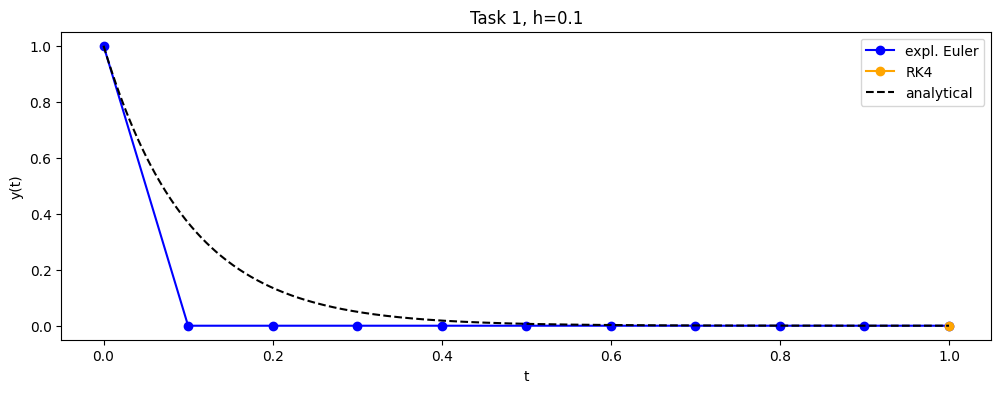

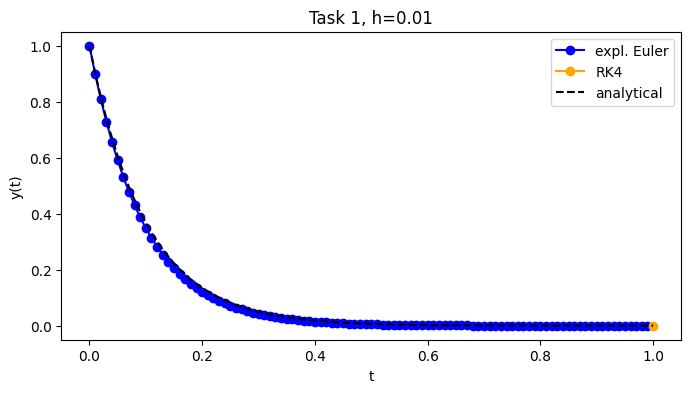

In [16]:
########### h = 0.1 ##########
h = 0.1

plt.figure(figsize=(12, 4))
t_euler, y_euler = euler(ode_f, t0, y0, t_end, h)
t_rk4, y_rk4 = rk4(ode_f, t0, y0, t_end, h)

# Plot Euler and RK4 methods with analytical solution
plt.plot(t_euler, y_euler, 'o-', label='expl. Euler', color='blue')
plt.plot(t_rk4, y_rk4, 'o-', label='RK4', color='orange')
plt.plot(t_exact, y_exact, '--', label='analytical', color='black')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Task 1, h=0.1')
plt.legend()
plt.show()

########## h = 0.01 ##########
h = 0.01

plt.figure(figsize=(8, 4))
t_euler, y_euler = euler(ode_f, t0, y0, t_end, h)
t_rk4, y_rk4 = rk4(ode_f, t0, y0, t_end, h)

# Plot Euler and RK4 methods with analytical solution
plt.plot(t_euler, y_euler, 'o-', label='expl. Euler', color='blue')
plt.plot(t_rk4, y_rk4, 'o-', label='RK4', color='orange')
plt.plot(t_exact, y_exact, '--', label='analytical', color='black')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Task 1, h=0.01')
plt.legend()
plt.show()



### Plot RK2(3)

In [14]:
# Set Test Conditions
y0, t0, t_end, h0, safety_factor = 1, 0, 1, 0.1, 0.5 

# Compute Analytical Solution
t_exact = np.linspace(t0, t_end, 1000)
y_exact = analytical_solution(t_exact)

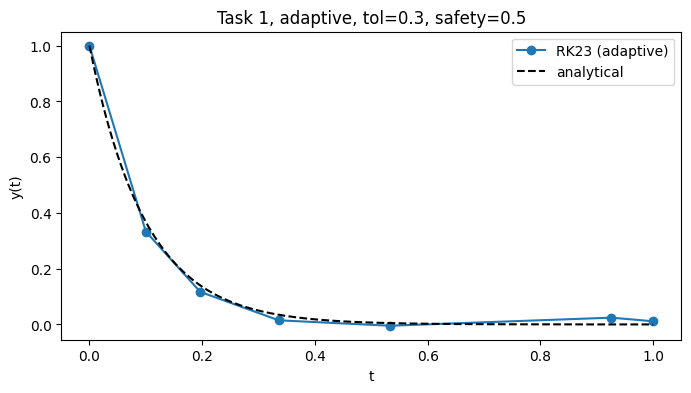

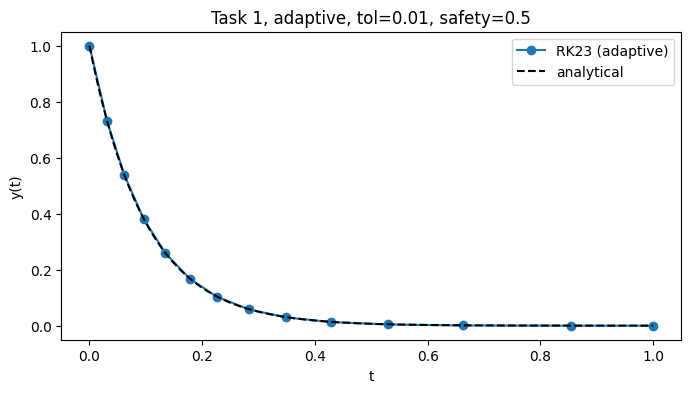

In [15]:
# Plot RK2(3) and analytical solution

########### tol = 0.3 ##########
tol = 0.3

plt.figure(figsize=(8, 4))
t_rk23, y_rk23 = adaptive_rk23(ode_f, y0, t0, t_end, h0, tol, safety_factor)

plt.plot(t_rk23, y_rk23, 'o-', label='RK23 (adaptive)')
plt.plot(t_exact, y_exact, '--', label='analytical', color='black')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Task 1, adaptive, tol=0.3, safety=0.5')
plt.legend()
plt.show()

########### tol = 0.01 ##########
tol = 0.01

plt.figure(figsize=(8, 4))
t_rk23, y_rk23 = adaptive_rk23(ode_f, y0, t0, t_end, h0, tol, safety_factor)

plt.plot(t_rk23, y_rk23, 'o-', label='RK23 (adaptive)')
plt.plot(t_exact, y_exact, '--', label='analytical', color='black')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Task 1, adaptive, tol=0.01, safety=0.5')
plt.legend()
plt.show()

# Task 2

### Initial conditions and parameters

In [ ]:
# Constant values
mu = 0.012277471
mu_hat = 1 - mu
T = 17.06521656015796
y0 = np.array([0.994, 0, 0, -2.001585106376082])

tol = 0.001
lambd = 0.5 # safety-factor
h0 = 0.1


### Define the satellite equations

In [ ]:
# Define ODE System

def arenstorf_orbit(t, state):
    x_1, x_2, x_1_dot, x_2_dot = state  
    
    N_1 = ((x_1 + mu)**2 + x_2**2)**(3/2)
    N_2 = ((x_1 - mu_hat)**2 + x_2**2)**(3/2)

    x_1_ddot = x_1 + 2 * x_2_dot - mu_hat * ((x_1 + mu) / N_1) - mu * ((x_1 - mu_hat) / N_2)
    x_2_ddot = x_2 - 2 * x_1_dot - mu_hat * (x_2 / N_1) - mu * (x_2 / N_2)

    return np.array([x_1_dot, x_2_dot, x_1_ddot, x_2_ddot])

### Solve the satellite problem

In [ ]:
t0 = 0
t_end = T

# Solve the satellite problem
t, y = adaptive_rk23(arenstorf_orbit, y0, t0, t_end, h0, tol, safety_factor)

### Plot

In [ ]:
# Store coordinate values
x1 = []
x2 = []
for i in range(len(y)):
    x1.append(y[i][0])
    x2.append(y[i][1])

# Store time step size
step_num = np.linspace(1, len(t), len(t)-1)
dt = []
for i in range(1, len(t)):
    dt.append(abs(t[i] - t[i-1]))


plt.figure(figsize=(12, 5))  

# Plot trajectory on the left
plt.subplot(1,2,1)
plt.plot(x1, x2, label='RK23 (adaptive)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Plot step size on the right
plt.subplot(1,2,2)
plt.plot(step_num, dt, label='time step size')
plt.legend(loc = 'upper left')
plt.xlabel('step number')
plt.ylabel('dt')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Increase horizontal space between subplots

# Show the plots
plt.show() 


# Task 3

### Initial conditions and parameters

In [ ]:
# Parameters
y0, t0, t_end = 1, 0, 1

# Step sizes for Euler and RK4
step_sizes = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
num_step = []
num_step = [1 / h for h in step_sizes]

### Define the ODE and exact solution

In [ ]:
# Define the ODE and exact solution
def f(t, y):
    return 3 * np.exp(-4 * t) - 2 * y

def exact_sol(t):
    return 2.5 * np.exp(-2 * t) - 1.5 * np.exp(-4 * t) 

# y'(0) = 3 * exp(0) - 2 * y(0) = 3-2 = 1 and y(0) = 1 
# x(0) = a + b = 1
# x'(0) = -2a - 4b = 1
# a = 2.5 and b = -1.5

### Compute errors for Euler and RK4 and RK23

In [ ]:
######## Euler and RK4 method ######## 
err_euler = [] # init error lists
err_rk4 = []

for h in step_sizes:
    t_euler, y_euler = euler_method(f, t0, y0, t_end, h)
    err_euler.append(np.max(abs(y_euler - np.vectorize(exact_sol)(t_euler)))) # err_euler = max|y_euler - y_exact|

    t_rk4, y_rk4 = rk4_method(f, t0, y0, t_end, h)
    err_rk4.append(np.max(abs(y_rk4 - np.vectorize(exact_sol)(t_rk4)))) # err_rk4 = max|y_rk4 - y_rk4|


######## Adaptive RK23 method ######## 
h0 = 0.1
tolerances = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001] #with various tolerances
lambd = 0.5

err_adaptive_rk23 = [] # init an error list 
adaptive_rk23_steps = [] # init num_step list

for tol in tolerances:
    t_adaptive_rk23, y_adaptive_rk23 = adaptive_rk23(f, y0, t0, t_end, h0, tol, lambd)
    err_adaptive_rk23.append(np.max(abs(y_adaptive_rk23 - np.vectorize(exact_sol)(t_adaptive_rk23))))
    # err_rk23 = max|y_rk23 - y_rk23|
    adaptive_rk23_steps.append(len(t_adaptive_rk23))

# Define the slopes
num_step_start = num_step[0]
num_step_values = np.linspace(np.min(num_step), np.max(num_step), 1000)
num_step_adaptive_start = adaptive_rk23_steps[0]
num_step_adaptive_values = np.linspace(np.min(adaptive_rk23_steps), np.max(adaptive_rk23_steps), 1000)

slope1 = 10**0 * (num_step_values/ num_step_start)**(-1)
slope3 = 10**(-2) * (num_step_adaptive_values/num_step_adaptive_start)**(-3)
slope4 = 10**(-2) * (num_step_values/ num_step_start)**(-4)


### Plot

In [ ]:
# Plot the results
plt.loglog(num_step, err_rk4,  color='blue',marker='o', label='error RK4')
plt.loglog(num_step, err_euler, color='orange',marker='o', label='error Euler')
plt.loglog(adaptive_rk23_steps, err_adaptive_rk23, color='green',marker='o', label='error adaptive RK23')

plt.loglog(num_step_values,slope1, color='black', label='slope1')
plt.loglog(num_step_adaptive_values, slope3, linestyle='-.', color='black', label='slope3')
plt.loglog(num_step_values,slope4, linestyle='--', color='black', label='slope4')

plt.xlabel('n_steps')
plt.ylabel('Linf error')
plt.legend()
plt.show()